In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

First, we load the data and check the types of data.

In [2]:
# load data
df = pd.read_csv('hw1_dataset.csv')

# analyze data type
df.dtypes

experimental_proprty    float64
MS_enc                   object
nHetero                   int64
nX                        int64
C2SP3                     int64
                         ...   
AATSC1dv                float64
nFARing                   int64
AATS2v                  float64
Xp-7dv                  float64
n6Ring                    int64
Length: 552, dtype: object

As we have seen above, some columns contain objects, while most of them are numeric. Let's print all columns with object type.

In [3]:
df.select_dtypes('object').head()

,MS_enc,MIF,SMIF
0,PPENPINEAPLE42,Computation failed,bigger
1,PPENPINEAPLE42,59,the_biggest
2,PPENPINEAPLE42,37,big
3,HTXPTDWTTWOBJR,46,bigger
4,PPENPINEAPLE42,55,bigger


Next, we need to process these data. The *MS_enc* column contains only strings so we don't need that in the further analysis. The *MIF* column contains missing data (such as *Computation failed*) so we replace that with NaN. And finally, the *SMIF* column contains three distinct values, *big*, *bigger*, and *the_biggest*, and we replace that with 0, 1 and 2.

In [4]:
# process data
df = df.drop('MS_enc', axis=1)
df['MIF'] = pd.to_numeric(df['MIF'], errors='coerce')
df['SMIF'] = df['SMIF'].replace({'big': 0, 'bigger': 1, 'the_biggest': 2})

Now we are able to find outliers with z-scores. We filter out all entries with z-score greater than 10, and see how many outliers are found.

In [5]:
# find and remove outliers
z_scores = df.select_dtypes(np.number).apply(zscore)
threshold = 10
outliers = (np.abs(z_scores) > threshold)
df_outlier_removed = df[outliers.sum(axis=1)==0]
outliers.sum().sort_values(ascending=False)  # outliers count

SdNH        8
SdsN        7
StCH        7
SdsCH       6
AATSC0v     3
           ..
ATSC3pe     0
Zagreb1     0
ATSC4are    0
SZ          0
n6Ring      0
Length: 551, dtype: int64

This shows the number of outliers found in each feature. To help understand how these outliers look in the data, we will visualize three columns. Eight outliers were removed in the first feature, three in the second one, and no outliers were found in the last one.

Text(0.5, 1.0, 'Checking Outliers')

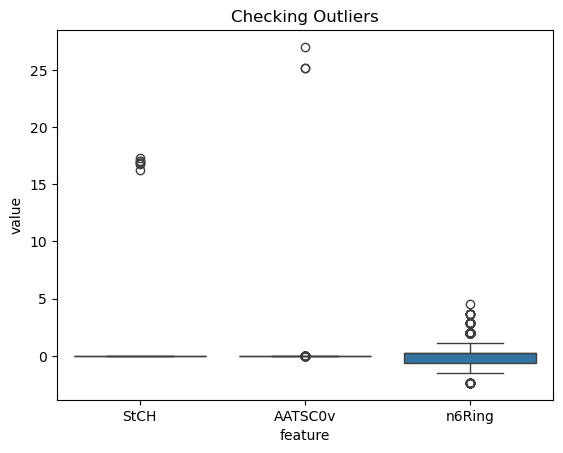

In [6]:
df_melted = z_scores[['StCH', 'AATSC0v', 'n6Ring']].melt(var_name='feature', value_name='value')
sns.boxplot(x='feature', y='value', data=df_melted)
plt.title('Checking Outliers')

Now we are ready to check the correlations. We start with generating a correlation matrix, and change all values on the diagnol to zero because we each feature is always correlated to itself. The following chart shows some feature pairs with high correlation.

In [7]:
# check correlations
correlation_matrix = df_outlier_removed.corr()
n_feature = correlation_matrix.shape[0]
correlation_matrix = correlation_matrix - np.identity(n_feature)  # remove trivial pairs
corr_pairs = pd.DataFrame(correlation_matrix.unstack(), columns=['correlation'])
corr_pairs[abs(corr_pairs['correlation'])>0.999]

correlation
ATS0i  Si          0.999207
nCl    NsCl        1.000000
       SsCl        0.999388
MW2    MIF6        1.000000
       MW          1.000000
...                     ...
ATS5se ATS5are     0.999215
ATS4se ATS4pe      0.999333
       ATS4are     0.999198
SsCl   nCl         0.999388
       NsCl        0.999388

[126 rows x 1 columns]

Since there are many pairs with very high correlation, we can also check those pairs with correlation equals to one, which means some of the features are redundant here.

In [8]:
corr_pairs[abs(corr_pairs['correlation'])>=1]

correlation
nCl       NsCl               1.0
MW2       MIF6               1.0
          MW                 1.0
nBondsA   nAromBond          1.0
n9FaRing  n9FaHRing          1.0
nF        NsF                1.0
MIF       nAtom              1.0
NsCl      nCl                1.0
n5aRing   n5aHRing           1.0
MIF6      MW2                1.0
n5aHRing  n5aRing            1.0
MW        MW2                1.0
nAromBond nBondsA            1.0
n9FaHRing n9FaRing           1.0
NsF       nF                 1.0
MWC01     nBondsO            1.0
nAtom     MIF                1.0
nBondsO   MWC01              1.0

In order to check if there are features that correlated to the target variable, we sort the absolute correlation coefficient. As we can see, *SLogP* is the most correlated feature.

In [9]:
# check correlation with the target variable
correlation_matrix['experimental_proprty'].abs().sort_values(ascending=False)

SLogP                   0.427300
FilterItLogS            0.374267
BalabanJ                0.342566
nAromAtom               0.325715
nBondsA                 0.323944
                          ...   
ATSC2pe                 0.000206
experimental_proprty    0.000000
MIF2                         NaN
MIF3                         NaN
StCH                         NaN
Name: experimental_proprty, Length: 551, dtype: float64

We can visualize the correlation between *experimental_proprty* and *SLogP*. The 0.43 is not a very high coefficient, while we can roughly see the pattern.

Text(0.5, 1.0, 'Most Correlated Feature to the Target Variable')

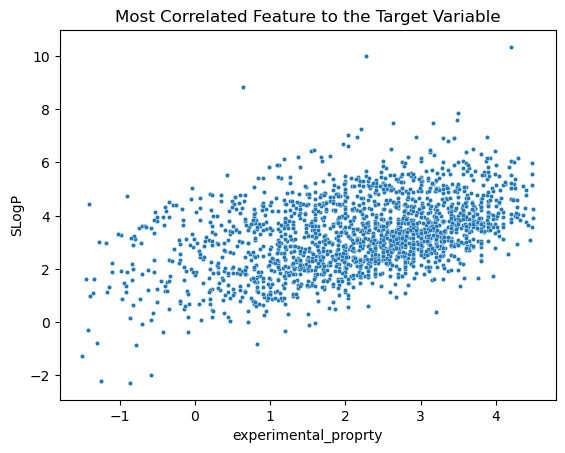

In [10]:
# plot correlation with the target variable
sns.scatterplot(
    data=df_outlier_removed,
    x='experimental_proprty',
    y='SLogP',
    s=10
)
plt.title('Most Correlated Feature to the Target Variable')

To process mising data, we need to find the columns with NaN or Null entries. The only two columns in our data frame are *MW2* and *MIF*.

In [11]:
# process missing data
df_outlier_removed.columns[df_outlier_removed.isna().any()]

Index(['MW2', 'MIF'], dtype='object')

Luckily, we have already seen these two columns while checking the correlations. They are both fully correlated to some other features, so we can simply drop them.

In [12]:
df_na_dropped = df_outlier_removed.drop(['MW2', 'MIF'], axis=1)

In order to perform the following techniques, we need to seperate the target from other features and scale the data.

In [13]:
# seperate target from features and scale the data
features = df_na_dropped.drop(columns=['experimental_proprty'])
target = df_na_dropped['experimental_proprty']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

Now we are able to use principal component analysis to reduce the dimensionality. Let's try to explain the 95% of the variance first.

In [14]:
# PCA
pca = PCA(0.95)
pca_result = pca.fit_transform(scaled_features)
len(pca.explained_variance_ratio_)

57

It turns out that we still need 57 components! This is too much for visualization, so we only keep two most important components for the following analysis.

In [15]:
# PCA in 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['experimental_proprty'] = target
pca_df

,PC1,PC2,experimental_proprty
0,-4.542592,5.279724,3.54
1,14.589471,-3.423402,-1.18
2,-9.406434,0.320189,3.69
3,2.479393,-6.917082,3.37
4,1.527997,5.623797,3.10
...,...,...,...
1950,17.516779,-2.081420,2.40
1951,-5.275950,5.209051,2.82
1952,2.274215,5.563139,2.93
1953,-0.114020,-9.051159,2.80


We have a dataframe of the values of the first two components and the target property, so we may visualize it. The color in the scatter plot below indicates the different ranges of *experimental property*. Ideally, we want a few clusters for different color, while this is not possible for only two dimensions. 

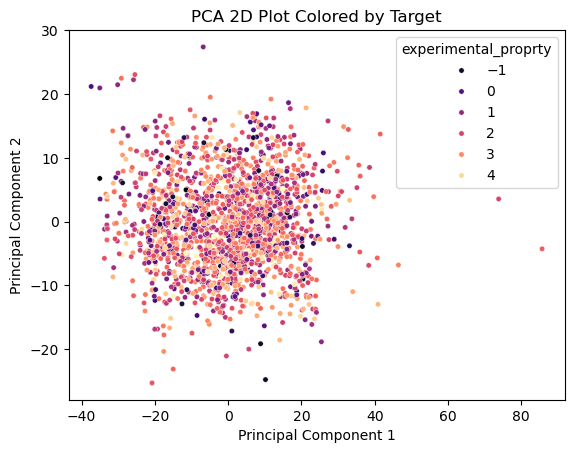

In [16]:
# plot PCA
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='experimental_proprty',
    palette="magma",
    s=15
)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA 2D Plot Colored by Target')
plt.show()

Bonus Questions 1:

In addition to PCA, we may use the t-distributed stochastic neighbor embedding. Although we can change the perplexity, the result is still not informative enough to see the pattern.

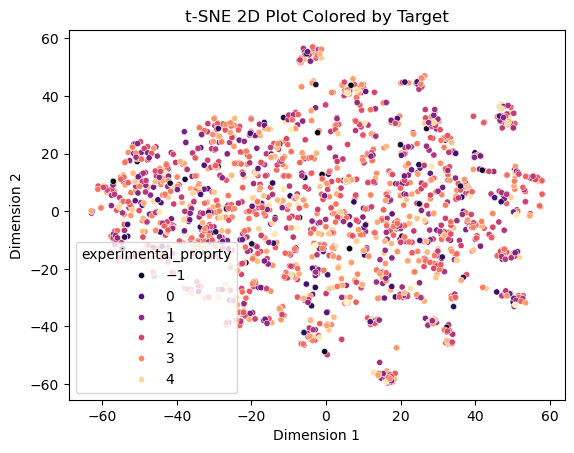

In [17]:
# tSNE
tsne = TSNE(n_components=2, perplexity=25)
tsne_result = tsne.fit_transform(scaled_features)
tsne_df = pd.DataFrame(data=tsne_result, columns=['Dim1', 'Dim2'])
tsne_df['experimental_proprty'] = target

# plot tSNE
sns.scatterplot(
    data=tsne_df,
    x='Dim1',
    y='Dim2',
    hue='experimental_proprty',
    palette='magma',
    s=20
)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE 2D Plot Colored by Target')
plt.show()

Bonus Questions 2:

In order to uncover the hidden pattern, we can also train a random forest regressor with 100 trees. We first split our data into training and testing sets and then train the modal. Finally, we evaluate the performance of this regressor by visualizing the residuals. A good regressor should result in residuals relatively close to zero.

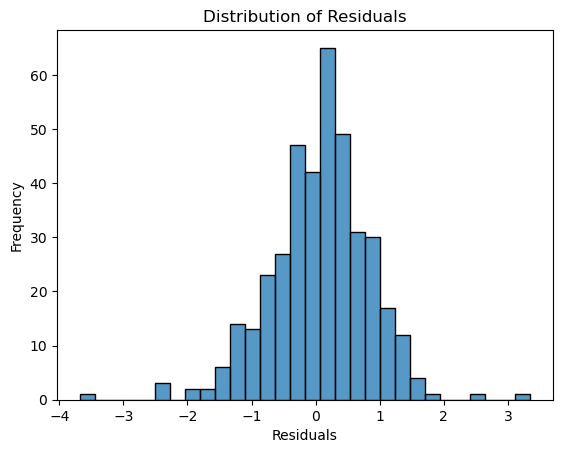

In [18]:
# train random forest regressor
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)
rf_reg = RandomForestRegressor(n_estimators=100)
rf_reg.fit(X_train, y_train)

# evaluate the modal
y_pred = rf_reg.predict(X_test)

# visualize residuals
residuals = y_test - y_pred
sns.histplot(residuals, bins=30)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

Conclusion:
In some sense, we failed to find a clear relationship between the features and the target property. Neither the PCA nor the tSNE produces satisfying results after reducing the dimensionality. The random forest regressor used all features, while its accuracy is limited.